# Task 2: CNN with PyTorch
# CENG501 - Spring 2023 - PA2

In this task, you will implement a convolutional neural network (CNN) with PyTorch. 


## 1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [ ]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import time                     # For measuring time
import random                   # Python's random library

# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms

# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary


%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 Enable GPU

From "Edit -> Notebook Settings -> Hardware accelerator" select GPU. With the following we will specify to PyTorch that we want to use the GPU.

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset. 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43244025.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.1 Visualize Samples

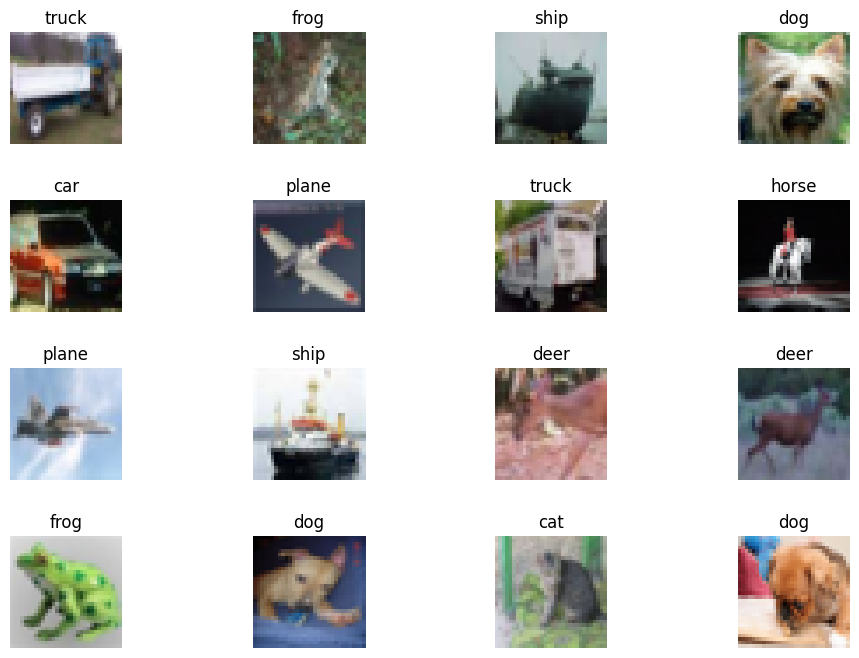

In [ ]:
dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = next(dataiter)
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 3 Define and Train a Small CNN Model

Now, all the pieces are ready and we can define a model.

### 3.1 Model Definition

Create a three-layer CNN with the following layers:

| Layer Name | Input HxW | Filter size | Stride | Pad | # of in channels | Out HxW | # of out channels | 
| ----| -----| ----| ---| ---| ----| -----|---------- |
| Conv1   | 32x32 | ? | ? | ? | 3  | 28x28 | 16 |
| Conv2   | 28x28 | ? | ? | ? | 16 | 26x26 | 32 |
| Maxpool | 26x26 | 4 | 2 | 0 | 32 | 12x12 | 32 |
| Conv3   | 12x12 | ? | ? | ? | 32 | 10x10 | 32 |

and the fully-connected layers:

| Layer Name | Input Size | Output size | 
| ----| -----| ----| 
| FC1 | 3200 | 1500 |
| FC2 | 1500 | 10 | 

You should choose suitable values for variables marked with `?' in the table and make sure that receptive fields can be properly placed in all layers. 

While creating your model, pay attention to the following aspects:
* Each Conv layer and FC layer will be followed by ReLU, except for the last one.
* You should keep all other parameters (dilation, bias, group-mode, ..) as their default values in Pytorch.

You will need to read the following pages from Pytorch regarding the layers that you will use:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)       
        ###########################################################
        # @TODO: Create the convolutional and FC layers as        #
        #  described above.                                       #
        ###########################################################
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=0) 
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=0) 
        self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=0)  

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(4, stride=2, padding=0)  

        # Fully connected layers
        self.fc1 = nn.Linear(32*10*10, 1500)
        self.fc2 = nn.Linear(1500, 10)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers. Note that x    #
      # needs to be reshaped to (batchsize, 3200) before        #
      # the FC layers.                                          #
      ###########################################################
      
      # Feedforward x
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.maxpool(x)
      x = F.relu(self.conv3(x))

      # Flatten x
      x = x.view(x.shape[0], -1)
      
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 3.2 Trainer for the Model

Let us define our training function, which will use the cuda device for training the model.

In [ ]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

### 3.3 Create and visualize the model

In [ ]:
model = SmallCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 28, 28]         1,216
├─Conv2d: 1-2                            [128, 32, 26, 26]         4,640
├─MaxPool2d: 1-3                         [128, 32, 12, 12]         --
├─Conv2d: 1-4                            [128, 32, 10, 10]         9,248
├─Linear: 1-5                            [128, 1500]               4,801,500
├─Linear: 1-6                            [128, 10]                 15,010
Total params: 4,831,614
Trainable params: 4,831,614
Non-trainable params: 0
Total mult-adds (G): 1.26
Input size (MB): 1.57
Forward/backward pass size (MB): 39.82
Params size (MB): 19.33
Estimated Total Size (MB): 60.72

### 3.4 Train the Small Model

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [ ]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 2.252824068069458
Epoch 1 / 10: avg. loss of last 5 iterations 1.9603222846984862
Epoch 2 / 10: avg. loss of last 5 iterations 1.7500268459320067
Epoch 3 / 10: avg. loss of last 5 iterations 1.6032060146331788
Epoch 4 / 10: avg. loss of last 5 iterations 1.5145578145980836
Epoch 5 / 10: avg. loss of last 5 iterations 1.4124666213989259
Epoch 6 / 10: avg. loss of last 5 iterations 1.3090994834899903
Epoch 7 / 10: avg. loss of last 5 iterations 1.2819221496582032
Epoch 8 / 10: avg. loss of last 5 iterations 1.2917486429214478
Epoch 9 / 10: avg. loss of last 5 iterations 1.2659758090972901


### 3.5 The Loss Curve

Let us visualize the loss curve.

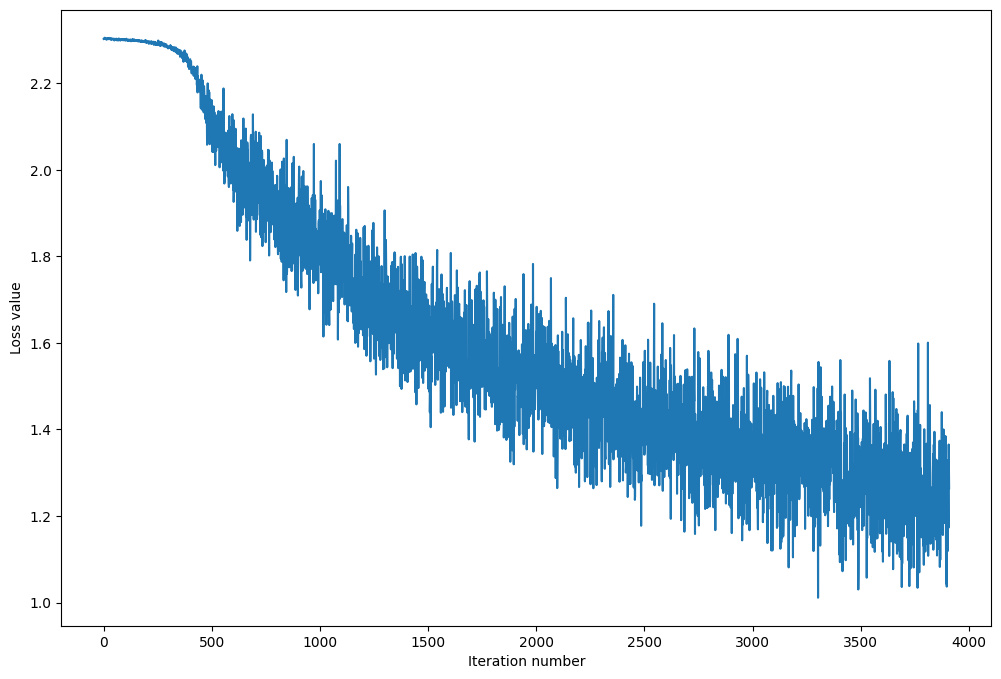

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 3.6 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 54\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


## 4 Your CNN

Now, create your own CNN. It should have at least 5 convolutional layers. Other than that, there is no restriction on what you can use in your CNN or how you can structure it. 


### 4.1 Model Definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class YourCNN(nn.Module):
    def __init__(self):
        super(YourCNN, self).__init__()
        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)       
        ###########################################################
        # @TODO: Create your layers here.                         #
        ###########################################################
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(4096, 1024) 
        self.fc2 = nn.Linear(1024, 512) 
        self.fc3 = nn.Linear(512, 10) 

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Batch normalization
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        ###########################################################
        #                         END OF YOUR CODE                #
        ###########################################################

    def forward(self, x):
      ###########################################################
      # @TODO: Feedforward x through the layers.                #
      ###########################################################
      
      x = F.relu(self.batch_norm1(self.conv1(x)))
      x = self.pool(F.relu(self.batch_norm1(self.conv2(x))))
      
      x = F.relu(self.batch_norm2(self.conv3(x)))
      x = self.pool(F.relu(self.batch_norm2(self.conv4(x))))
      
      x = F.relu(self.batch_norm3(self.conv5(x)))
      x = self.pool(F.relu(self.batch_norm3(self.conv6(x))))

      x = x.view(x.size(0), -1)

      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      ###########################################################
      #                         END OF YOUR CODE                #
      ###########################################################
      return x

### 4.2 Create and visuale your model

In [ ]:
model = YourCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,792
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Conv2d: 1-3                            [128, 64, 32, 32]         36,928
├─BatchNorm2d: 1-4                       [128, 64, 32, 32]         (recursive)
├─MaxPool2d: 1-5                         [128, 64, 16, 16]         --
├─Conv2d: 1-6                            [128, 128, 16, 16]        73,856
├─BatchNorm2d: 1-7                       [128, 128, 16, 16]        256
├─Conv2d: 1-8                            [128, 128, 16, 16]        147,584
├─BatchNorm2d: 1-9                       [128, 128, 16, 16]        (recursive)
├─MaxPool2d: 1-10                        [128, 128, 8, 8]          --
├─Conv2d: 1-11                           [128, 256, 8, 8]          295,168
├─BatchNorm2d: 1-12                      [12

### 4.3 Train the Model

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 0 / 10: avg. loss of last 5 iterations 1.3911950588226318
Epoch 1 / 10: avg. loss of last 5 iterations 1.0952116012573243
Epoch 2 / 10: avg. loss of last 5 iterations 0.9103875756263733
Epoch 3 / 10: avg. loss of last 5 iterations 0.8957590699195862
Epoch 4 / 10: avg. loss of last 5 iterations 0.6690355062484741
Epoch 5 / 10: avg. loss of last 5 iterations 0.6728903889656067
Epoch 6 / 10: avg. loss of last 5 iterations 0.5579199433326721
Epoch 7 / 10: avg. loss of last 5 iterations 0.5382434964179993
Epoch 8 / 10: avg. loss of last 5 iterations 0.5081428647041321
Epoch 9 / 10: avg. loss of last 5 iterations 0.4364182949066162


### 4.4 Loss Curve

Let us visualize the loss curve.

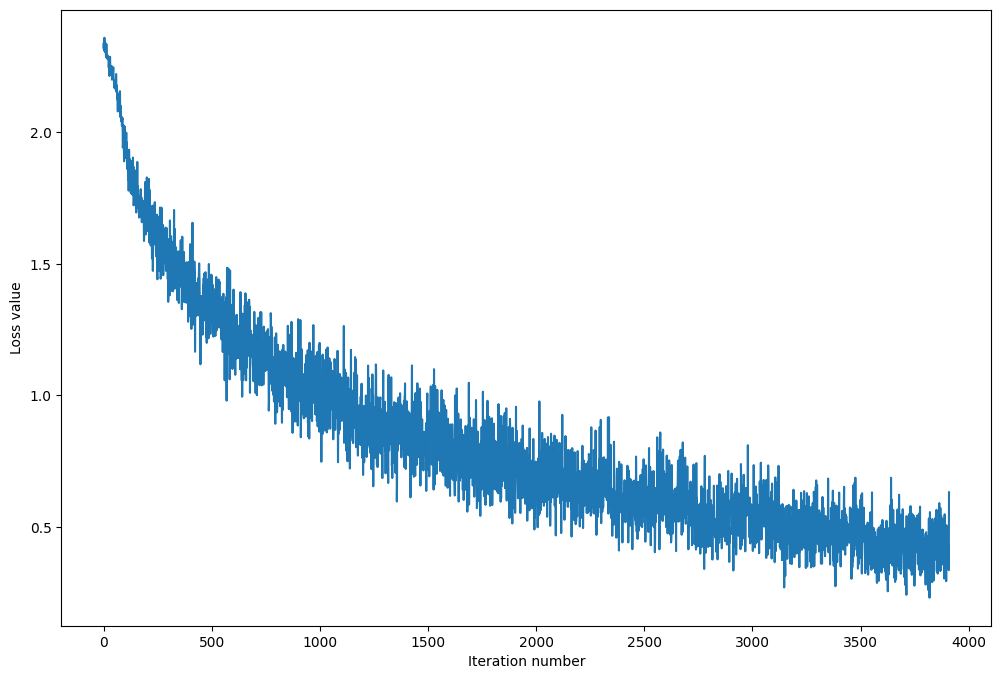

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 4.5 Quantitative Analysis

Analyze your model quantitatively.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [ ]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %
